In [20]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Path to your TensorBoard event file
EVENT_PATH = "results/events.out.tfevents.1743979679.hpc-node03.1802595.0"

# Metrics to extract
METRICS = [
    "train/loss_epoch", "train/acc", "train/top5_acc", "train/f1",
    "val/loss", "val/acc", "val/top5_acc", "val/f1"
]

# Extract data
data = defaultdict(list)
current_epoch = None

for e in summary_iterator(EVENT_PATH):
    for v in e.summary.value:
        tag = v.tag
        value = v.simple_value

        if tag == "epoch":
            current_epoch = int(value)
        elif tag in METRICS and current_epoch is not None:
            data[tag].append((current_epoch, value))

# Show what tags were found
print("Tags found in the event file:")
for tag in data:
    print(f"- {tag}")

# Build epoch list
epochs = sorted(set(ep for values in data.values() for ep, _ in values))

# Prepare data (skip if no data for that tag)
metric_curves = {}
for tag in METRICS:
    curve = []
    for epoch in epochs:
        values = [v for ep, v in data[tag] if ep == epoch]
        curve.append(values[-1] if values else None)
    if any(v is not None for v in curve):
        metric_curves[tag] = curve


Tags found in the event file:
- val/loss
- val/acc
- val/top5_acc
- val/f1
- train/loss_epoch
- train/acc
- train/top5_acc
- train/f1


{'train/loss_epoch': [1.2394095659255981, 1.1872533559799194, 1.169603943824768, 1.1394966840744019, 1.1237527132034302, 1.239018201828003, 1.12350332736969, 1.117085337638855, 1.1142020225524902, 1.1123192310333252], 'train/acc': [0.9343805909156799, 0.9470120072364807, 0.9548593759536743, 0.9685993194580078, 0.9737446308135986, 0.9437793493270874, 0.9742192029953003, 0.9757956862449646, 0.9764620065689087, 0.9769627451896667], 'train/top5_acc': [0.9949259757995605, 0.9991340041160583, 0.999605119228363, 0.9998109340667725, 0.9998947978019714, 0.9896302223205566, 0.999915599822998, 0.9999366998672485, 0.9999421834945679, 0.9999449849128723], 'train/f1': [0.1370564103126526, 0.20487259328365326, 0.4295371174812317, 0.6073364615440369, 0.728392481803894, 0.6589550971984863, 0.7979189157485962, 0.901556134223938, 0.9547329545021057, 0.9753700494766235], 'val/loss': [1.1932640075683594, 1.1797091960906982, 1.1483373641967773, 1.1238831281661987, 1.1154427528381348, 1.1259428262710571, 1.1

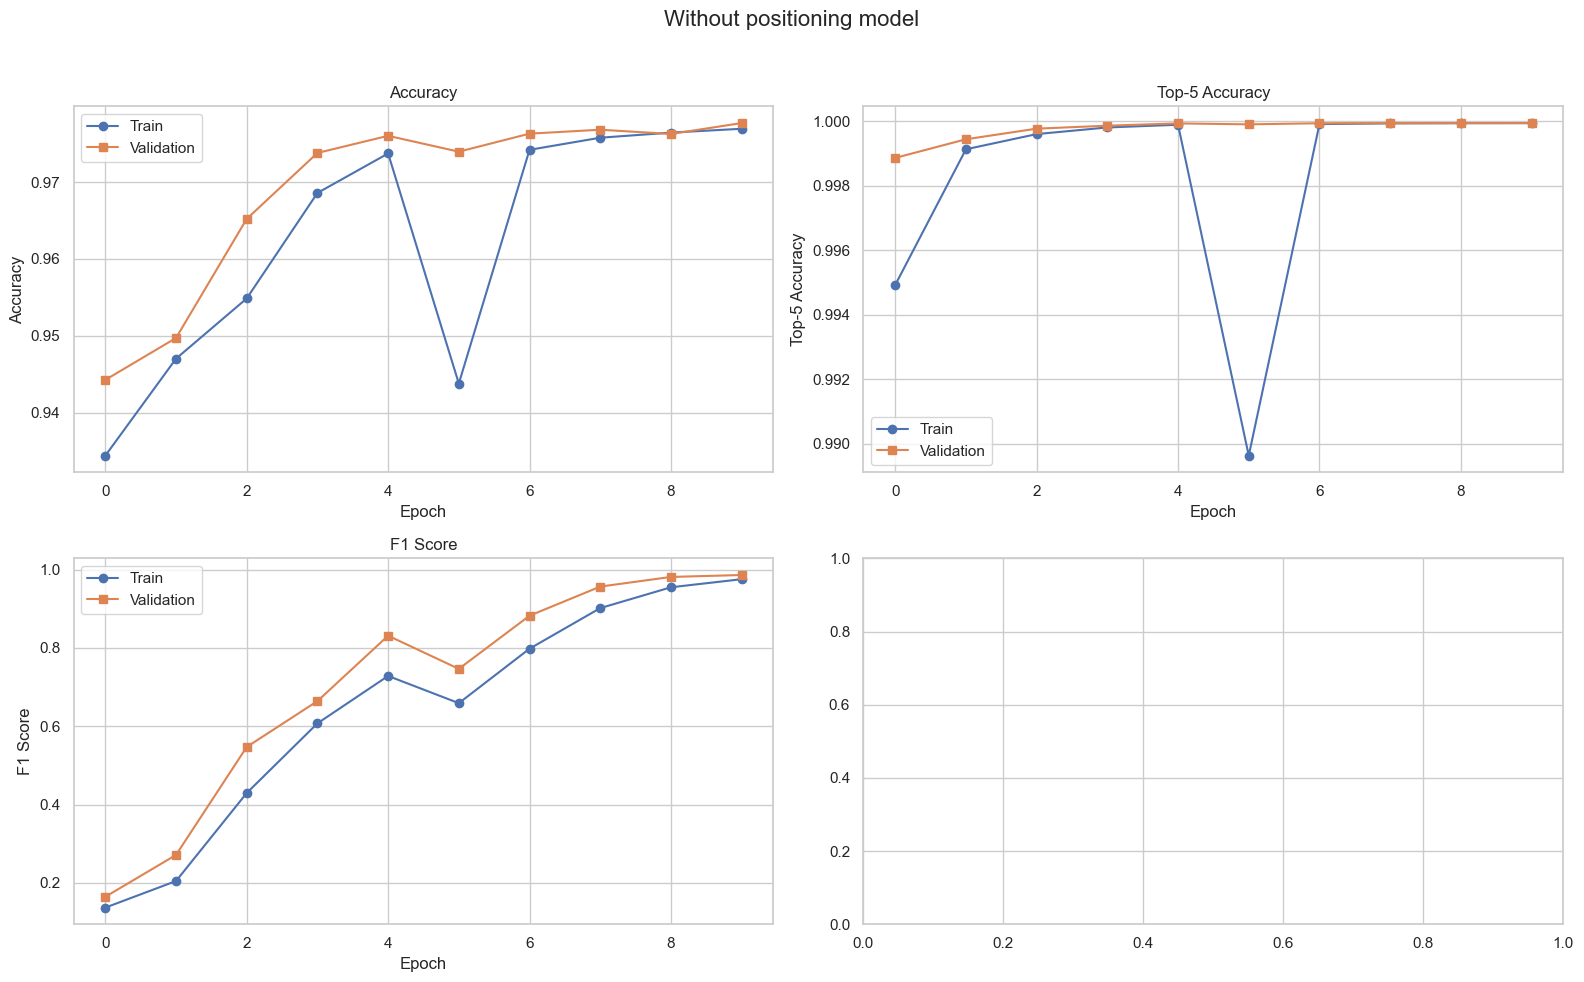

In [28]:
# Plotting
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

plot_titles = ["Accuracy", "Top-5 Accuracy", "F1 Score"]
metric_keys = ["acc", "top5_acc", "f1"]

print(metric_curves)

for ax, title, key in zip(axes, plot_titles, metric_keys):
    ax.plot(epochs, metric_curves[f"train/{key}"], label="Train", marker="o")
    ax.plot(epochs, metric_curves[f"val/{key}"], label="Validation", marker="s")
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(title)
    ax.legend()
    ax.grid(True)

fig.suptitle("Without positioning model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

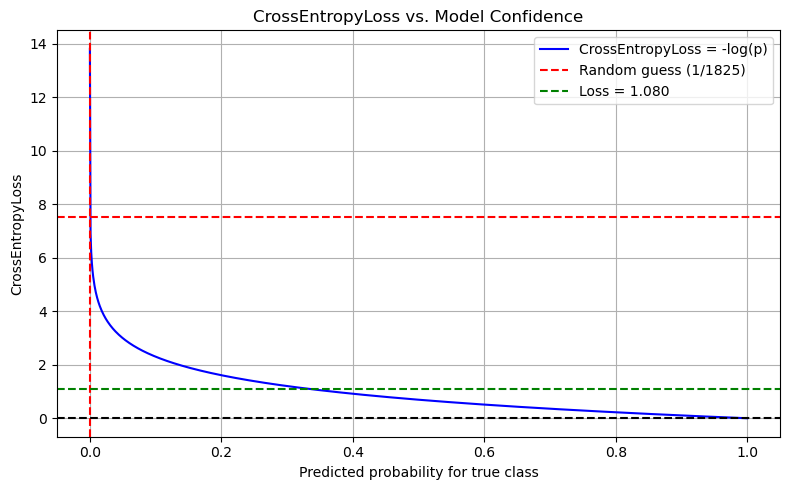

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Range of probabilities from very close to 0 to 1
probs = np.linspace(1e-6, 1.0, 1000)
loss = -np.log(probs)

plt.figure(figsize=(8, 5))
plt.plot(probs, loss, label='CrossEntropyLoss = -log(p)', color='blue')
plt.axvline(1/1825, color='red', linestyle='--', label='Random guess (1/1825)')
plt.axhline(-np.log(1/1825), color='red', linestyle='--')
plt.axhline(1.080, color='green', linestyle='--', label='Loss = 1.080')
plt.axhline(0, color='black', linestyle='--')

plt.xlabel('Predicted probability for true class')
plt.ylabel('CrossEntropyLoss')
plt.title('CrossEntropyLoss vs. Model Confidence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\Basva\\anaconda3\\envs\\logformer\\Lib\\site-packages\\matplotlib\\pyplot.py'>

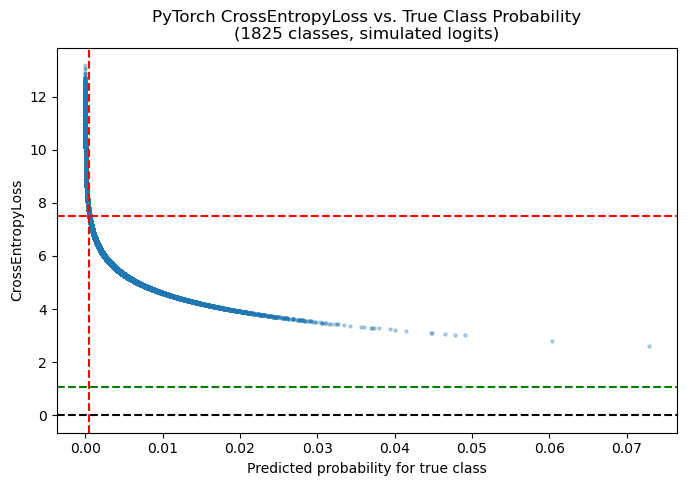

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Parameters
num_classes = 1825
n_samples = 10000000

# Storage
true_class_probs = []
losses = []

# Loss function (no reduction to get all values)
criterion = nn.CrossEntropyLoss(reduction='none')

for _ in range(n_samples):
    # Random logits (1 sample, num_classes)
    logits = torch.randn(1, num_classes)

    # Random true class index
    true_class = torch.randint(0, num_classes, (1,))

    # Compute loss (PyTorch applies log_softmax internally)
    loss = criterion(logits, true_class)

    # Get probability for the true class
    probs = torch.softmax(logits, dim=1)
    true_class_prob = probs[0, true_class].item()

    # Store results
    true_class_probs.append(true_class_prob)
    losses.append(loss.item())

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(true_class_probs, losses, alpha=0.3, s=5, label='Simulated logits (PyTorch formula)')
plt.axvline(1/num_classes, color='red', linestyle='--', label=f'Random guess (1/{num_classes})')
plt.axhline(-torch.log(torch.tensor(1/num_classes)).item(), color='red', linestyle='--')
plt.axhline(1.080, color='green', linestyle='--', label='Loss = 1.080')
plt.axhline(0, color='black', linestyle='--')

plt.xlabel('Predicted probability for true class')
plt.ylabel('CrossEntropyLoss')
plt.title(f'PyTorch CrossEntropyLoss vs. True Class Probability\n({num_classes} classes, simulated logits)')
plt


In [1]:
from models import LogTokenizer

tokenizer = LogTokenizer("drain3_state.bin")

config file not found: drain3.ini


In [2]:
with open("data\\BGL.log", "r", encoding="utf8") as f:
    data = [(tokenizer.get_event_id(line.split(maxsplit=9)[-1]), int(line.split(maxsplit=9)[1])) for line in f]  # Extract last column from each line

In [41]:
import pandas as pd
df = pd.DataFrame(data, columns=["event_id", "timestamp"])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

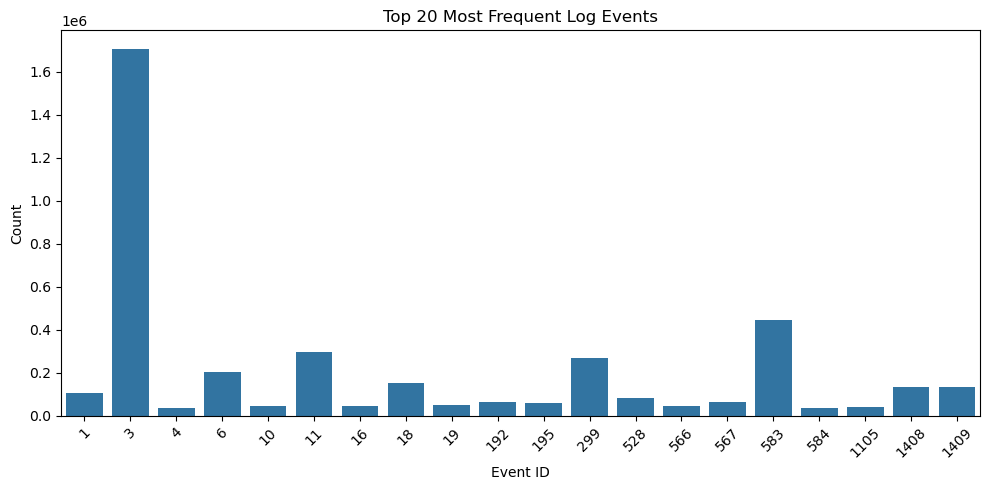

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

top_events = df["event_id"].value_counts().head(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_events.index, y=top_events.values)
plt.title("Top 20 Most Frequent Log Events")
plt.ylabel("Count")
plt.xlabel("Event ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

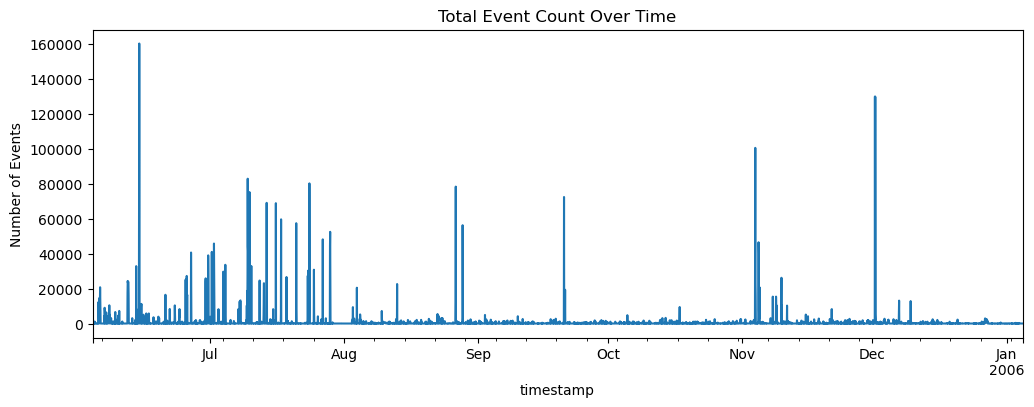

In [43]:
# Group by time intervals (e.g., 1 hour)
df.set_index("timestamp", inplace=True)
event_counts = df.resample("1h")["event_id"].count()

event_counts.plot(figsize=(12, 4), title="Total Event Count Over Time")
plt.ylabel("Number of Events")
plt.show()

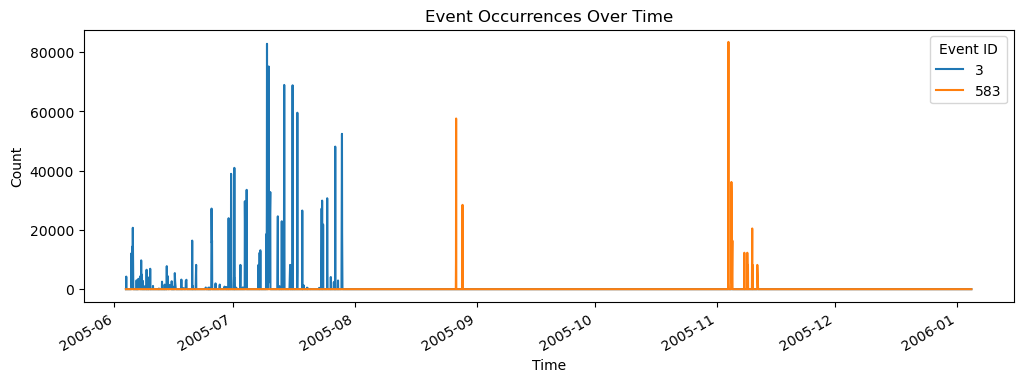

In [44]:
pivot = df.groupby([pd.Grouper(freq="1h"), "event_id"]).size().unstack(fill_value=0)

# Plot a few events over time
pivot[[3, 583]].plot(figsize=(12, 4))
plt.title("Event Occurrences Over Time")
plt.ylabel("Count")
plt.xlabel("Time")
plt.legend(title="Event ID")
plt.show()

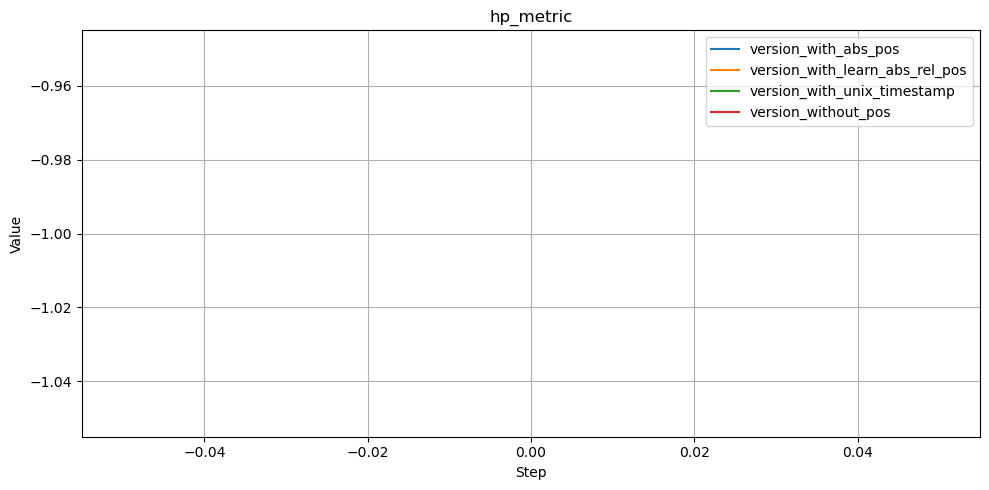

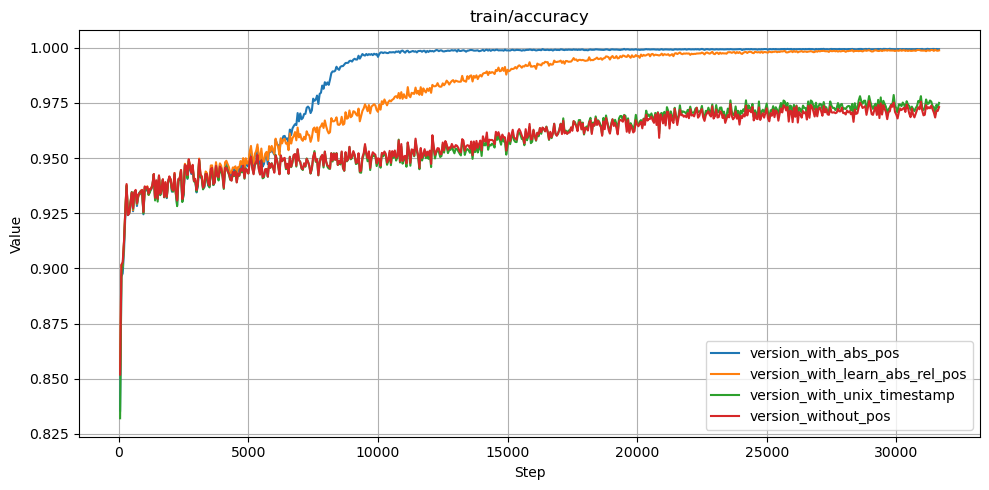

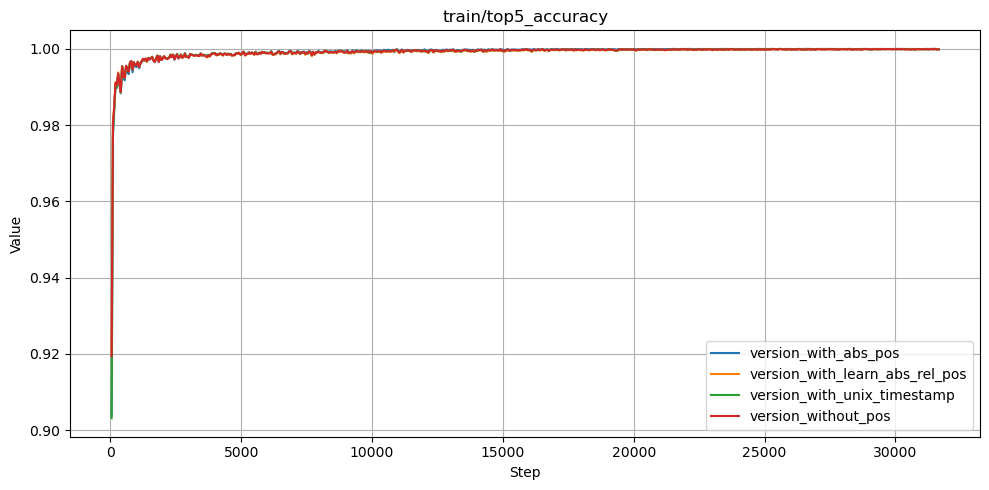

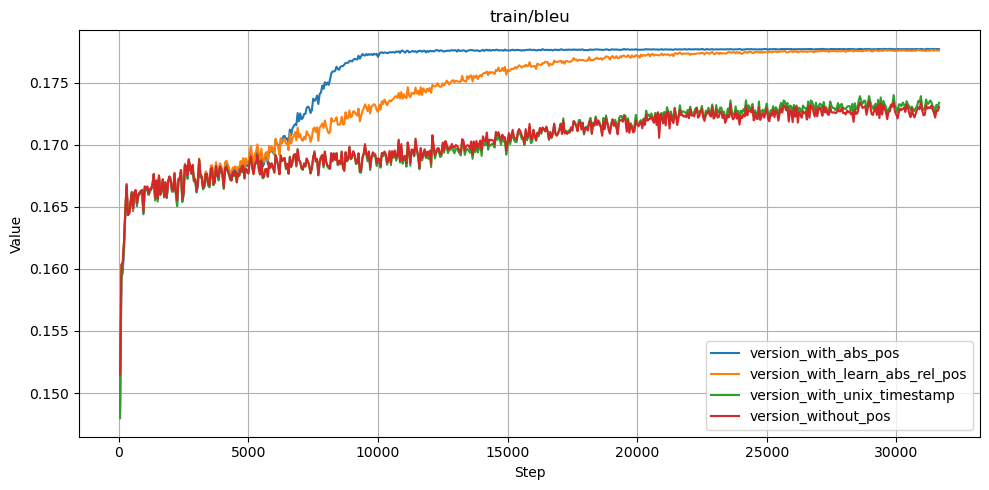

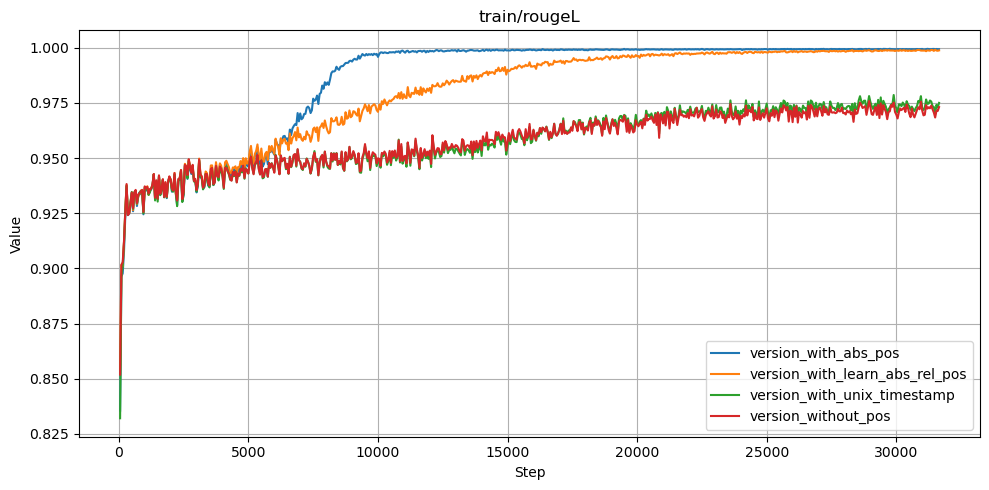

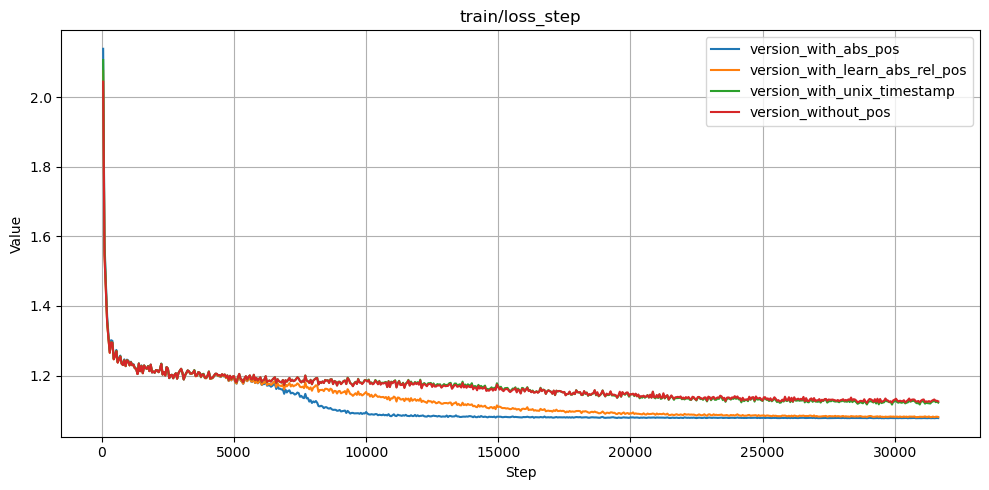

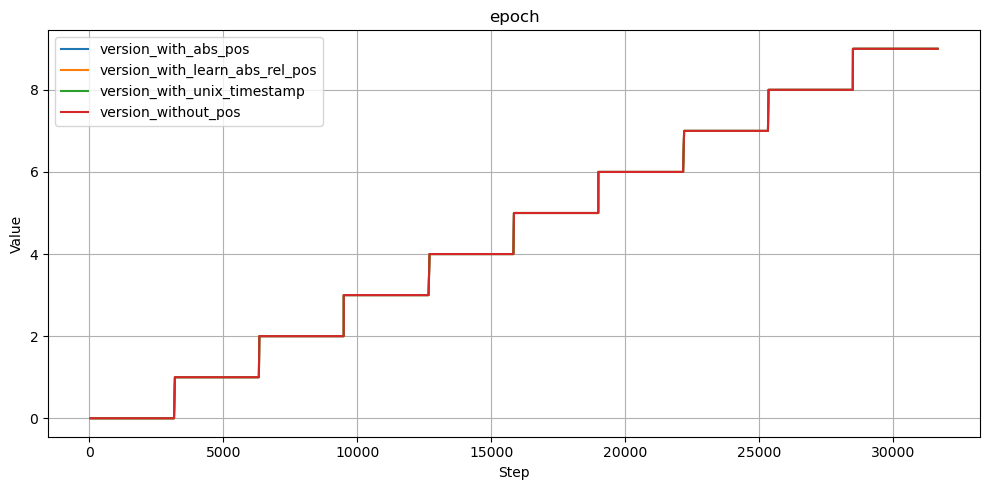

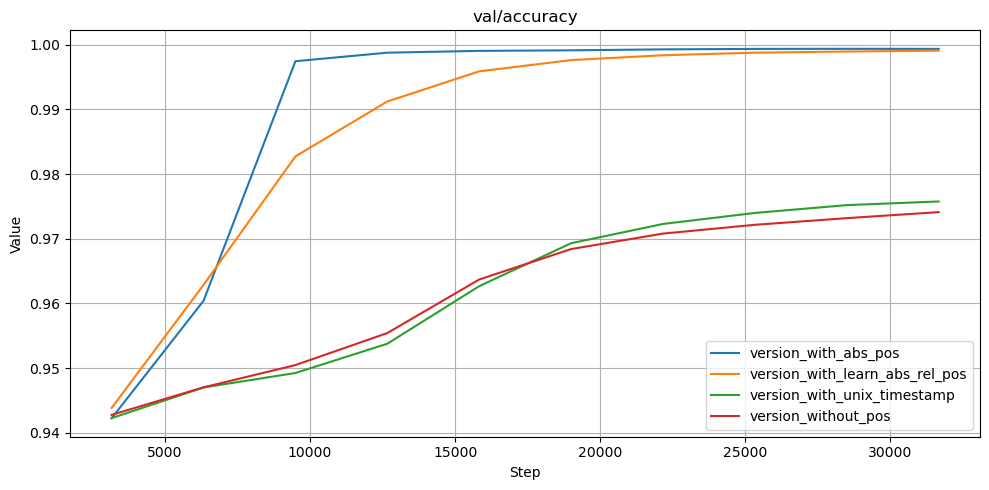

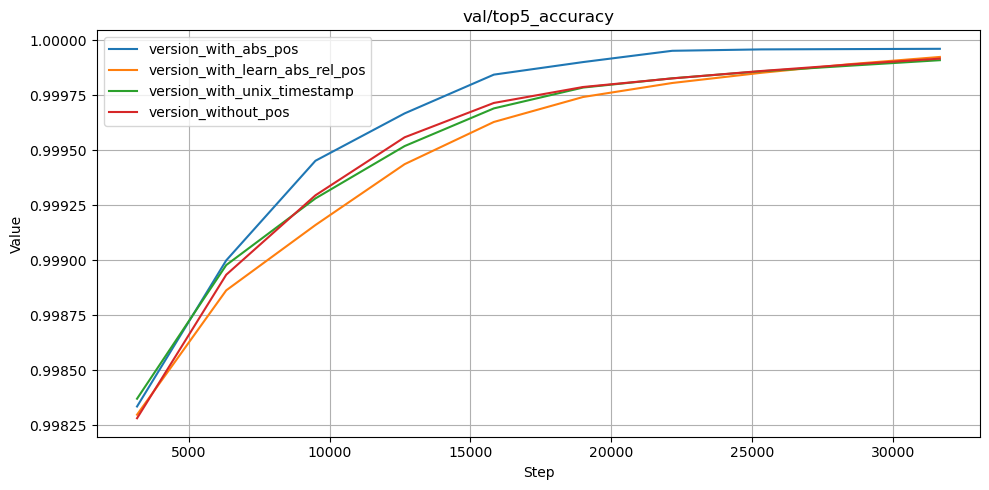

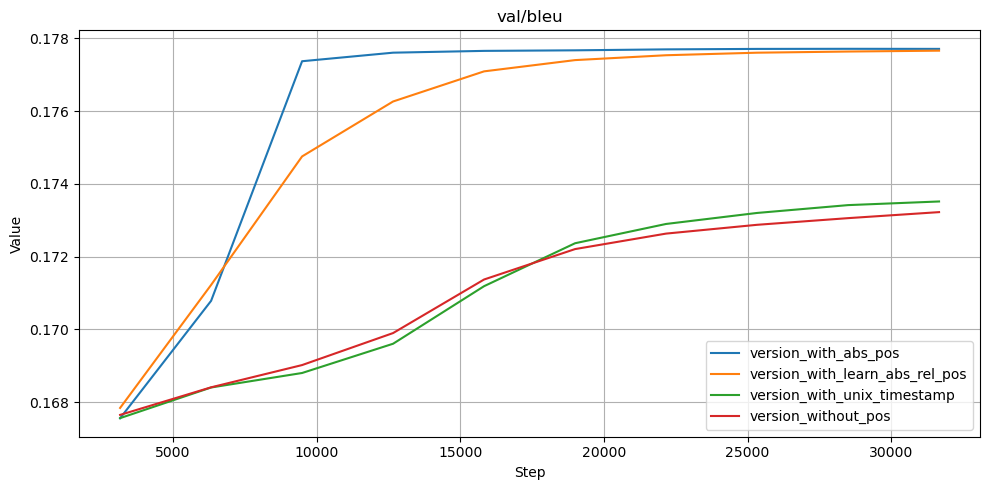

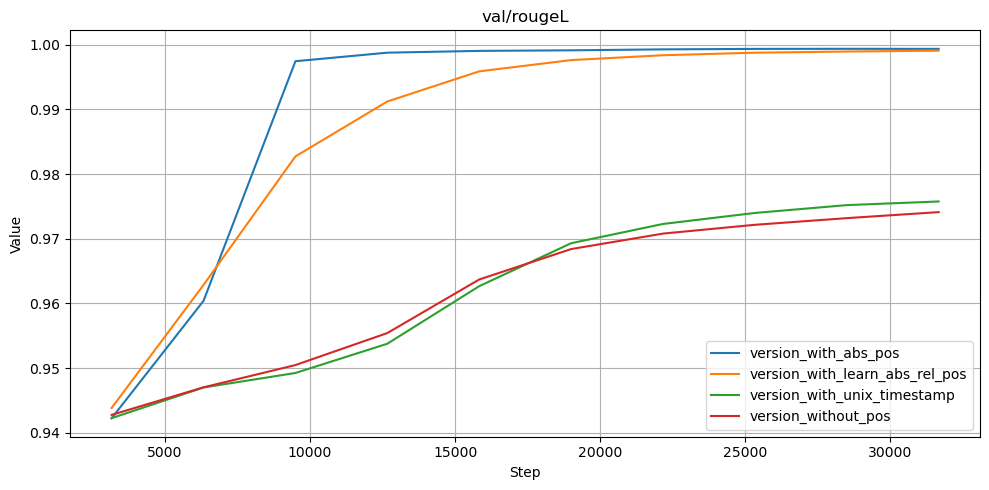

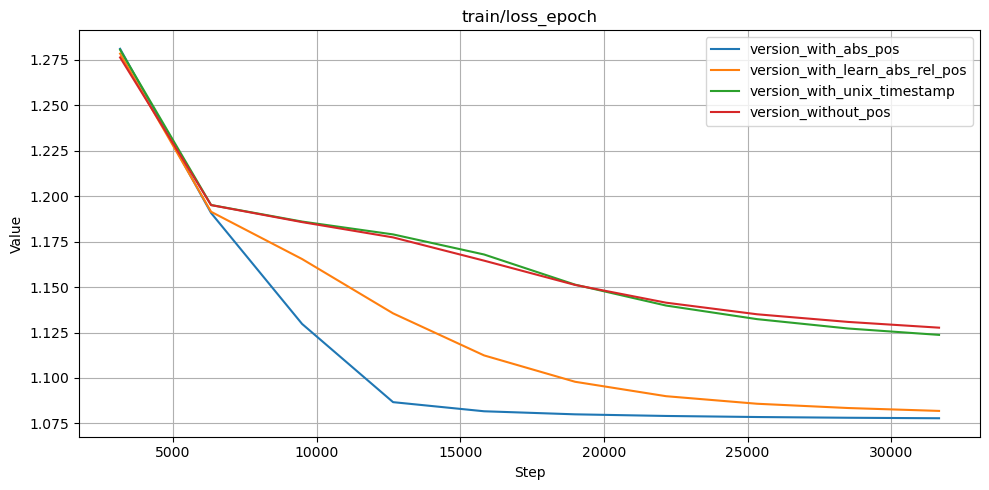

In [3]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

log_root = "./results"  # replace this with your actual path, e.g., "./results"
versions = sorted([v for v in os.listdir(log_root) if v.startswith("version_")])

def get_event_file(path):
    for file in os.listdir(path):
        if file.startswith("events.out.tfevents"):
            return os.path.join(path, file)
    return None

def get_all_tags(event_file):
    ea = EventAccumulator(event_file)
    ea.Reload()
    return ea.Tags().get("scalars", [])

def extract_scalars(event_file, tag):
    ea = EventAccumulator(event_file)
    ea.Reload()
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return steps, values

# Find all scalar tags from the first valid version
all_tags = []
for version in versions:
    path = os.path.join(log_root, version)
    event_file = get_event_file(path)
    if event_file:
        all_tags = get_all_tags(event_file)
        if all_tags:
            break

# Plot each metric
for tag in all_tags:
    plt.figure(figsize=(10, 5))
    for version in versions:
        path = os.path.join(log_root, version)
        event_file = get_event_file(path)
        if not event_file:
            continue
        try:
            steps, values = extract_scalars(event_file, tag)
            if steps and values:
                plt.plot(steps, values, label=version)
        except Exception as e:
            print(f"Error loading {tag} from {version}: {e}")
    
    plt.title(tag)
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
